In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import datetime
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import log_loss
from keras import __version__ as keras_version

np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


/home/venkat/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import pdb


from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import linear_model,decomposition
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
import scipy

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,SGDClassifier
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit

from scipy.sparse import coo_matrix, hstack ,vstack

import gc

print(gc.collect())

import xgboost as xgb


5


## Reading and printing a sample image

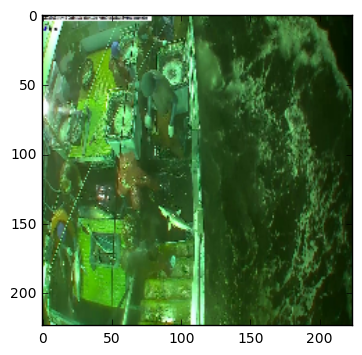

In [82]:
fl='train/SHARK/img_00072.jpg'
img = cv2.imread(fl)
img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR).astype(np.uint8)
im = img.transpose((2,0,1))
im = np.expand_dims(im, axis=0)

plt.imshow(img)

## Reading train data into numpy arrays

In [18]:
X_train = np.array([])
y_train=[]
start_time = time.time()


print('Read train images')
folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
for fld in folders:
    index = folders.index(fld)
    print('Load folder {} (Index: {})'.format(fld, index))
    path = os.path.join('train', fld, '*.jpg')
    files = glob.glob(path)
    for fl in files:
        flbase = os.path.basename(fl)
#             print fl
#             print flbase
#             img = cv2.imread(fl)
#             img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR).astype(np.uint8)
        img = img.transpose((2,0,1))
        img = np.expand_dims(img, axis=0)

        if X_train.size==0:
            X_train=img
        else:
            X_train=np.vstack([X_train,img])

        y_train.append(fld)

print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
y_train=np.array(y_train)


np.savez('fishers_train_data',X_train=X_train,y_train=y_train)

Read train images
Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder NoF (Index: 4)
Load folder OTHER (Index: 5)
Load folder SHARK (Index: 6)
Load folder YFT (Index: 7)
Read train data time: 253.16 seconds


## Loading saved train data

In [3]:
XX=np.load('fishers_train_data.npz')
y_train=XX['y_train']
X_train=XX['X_train']



## Printing sample images - one image from each class

ALB


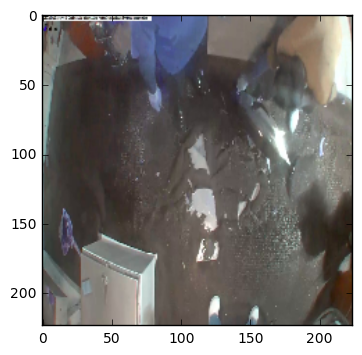

BET


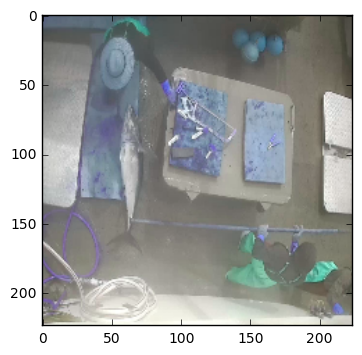

DOL


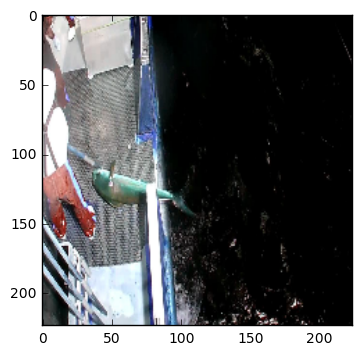

LAG


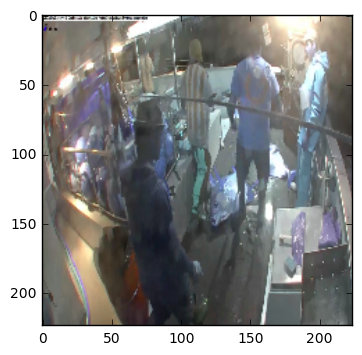

NoF


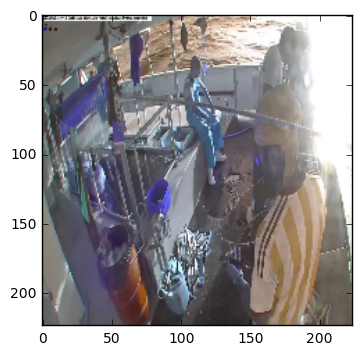

OTHER


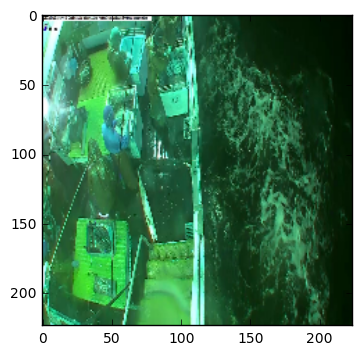

SHARK


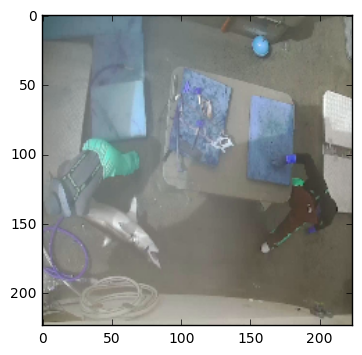

YFT


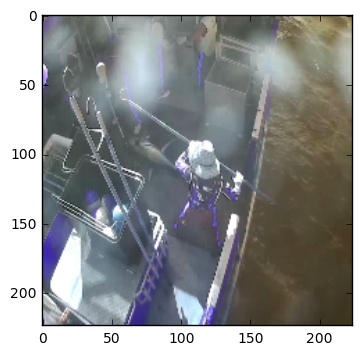

In [92]:
L=[]
for i in range(3777):
    if y_train[i] not in L:
        print y_train[i]
        L.append(y_train[i])
        pp=X_train[i].transpose((1,2,0))
        plt.imshow(pp)
        plt.show()

## Edge detection

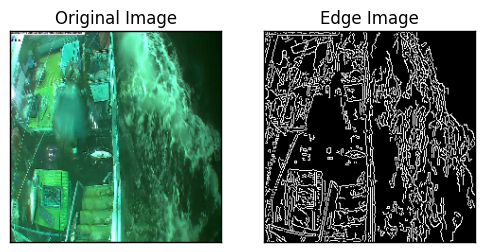

In [161]:
# img = cv2.imread('messi5.jpg',0)
img=X_train[120].transpose((1,2,0))
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Reading test data into numpy arrays

In [110]:
X_test = np.array([])
filename_test=[]
start_time = time.time()


print('Read test images')
path = os.path.join('test_stg1', '*.jpg')
files = glob.glob(path)
for fl in files:
    flbase = os.path.basename(fl)
    img = cv2.imread(fl)
    img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR).astype(np.uint8)
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, axis=0)

    if X_test.size==0:
        X_test=img
    else:
        X_test=np.vstack([X_test,img])
    
    filename_test.append(fl)

print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
filename_test=np.array(filename_test)
print X_test.shape
np.savez('fishers_test_data',X_test=X_test,filename_test=filename_test)

Read test images
Read train data time: 25.24 seconds
(1000, 3, 224, 224)


## Loading test data

In [4]:
XX=np.load('fishers_test_data.npz')
filename_test=XX[ 'filename_test' ]
X_test=XX['X_test' ]


## Getting the unique labels and encoding the labels

In [5]:
Labels=np.unique(y_train)
y_train_int=y_train
for ind,l in enumerate(Labels):
    y_train_int[np.argwhere(y_train==l)]=ind
y_train_int_ohe=np_utils.to_categorical(y_train_int)

In [6]:
print Labels
print len(Labels)


def create_submission(Ypred,Labels,filename_test,fname='mysubmission.csv'):
    df=pd.DataFrame(Ypred,columns=Labels)
    L=np.append(Labels,'image')
    if '/' in filename_test[1]: 
        for i in range(len(filename_test)):
            filename_test[i]=filename_test[i].split('/')[1]
    df['image']=filename_test
    df.to_csv(fname,index=False)


['ALB' 'BET' 'DOL' 'LAG' 'NoF' 'OTHER' 'SHARK' 'YFT']
8


## Normalizing data

In [7]:
X_train_norm=X_train.astype(float)/255
X_test_norm=X_test.astype(float)/255

## Getting a flat version of the data

In [8]:
X_train_norm_flat=X_train_norm.reshape(X_train_norm.shape[0],X_train_norm.shape[1]*X_train_norm.shape[2]*X_train_norm.shape[3])
X_test_norm_flat=X_test_norm.reshape(X_test_norm.shape[0],X_test_norm.shape[1]*X_test_norm.shape[2]*X_test_norm.shape[3])

In [9]:
X_train_norm_flat.shape

(3777, 150528)

In [10]:
X_train_norm_flat_split, X_test_norm_flat_split, y_train_norm_flat_split, y_test_norm_flat_split = train_test_split(
    X_train_norm_flat, y_train_int, test_size=0.33, random_state=42)

## Running random Forest - Kaggle score of 2.06 - not submitted


In [50]:


clf_rf = RandomForestClassifier(n_estimators=50,n_jobs=5,max_depth=2000)
clf_rf.fit(X_train_norm_flat_split,y_train_norm_flat_split)
Ypred=clf_rf.predict(X_test_norm_flat_split)

print ("\n***** Accuracy Score *****\n")
print (metrics.accuracy_score(y_test_norm_flat_split,Ypred))
print ("\n***** Classification report ***** \n")
print (metrics.classification_report(y_test_norm_flat_split,Ypred))
print( "\n***** Confusion Matrix ***** \n")
print ('\x1b[1;31m'+ str(metrics.confusion_matrix(y_test_norm_flat_split,Ypred) )+'\x1b[0m')
# print ("\n***** r2_score ***** \n")
# print (r2_score(y_test_norm_flat_split,Ypred))

Ypred=clf_rf.predict_proba(X_test_norm_flat)
create_submission(Ypred,Labels,filename_test,fname='mysubmission_rf.csv')


***** Accuracy Score *****

0.940657578188

***** Classification report ***** 

             precision    recall  f1-score   support

          0       0.91      0.98      0.95       590
          1       0.98      0.79      0.87        62
          2       1.00      0.97      0.99        37
          3       1.00      0.93      0.97        15
          4       0.96      0.81      0.88       156
          5       0.98      0.93      0.95        96
          6       1.00      1.00      1.00        57
          7       0.97      0.94      0.95       234

avg / total       0.94      0.94      0.94      1247


***** Confusion Matrix ***** 

[[581   0   0   0   4   1   0   4]
 [ 13  49   0   0   0   0   0   0]
 [  1   0  36   0   0   0   0   0]
 [  1   0   0  14   0   0   0   0]
 [ 28   0   0   0 126   0   0   2]
 [  5   0   0   0   0  89   0   2]
 [  0   0   0   0   0   0  57   0]
 [ 10   1   0   0   1   1   0 221]]


## Running Convolution NN - Kaggle loss score - 1.6 - submitted

In [149]:

batch_size = 16
nb_epoch = 20
random_state = 51



model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, 224, 224)))
model.add(Convolution2D(4, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(4, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(8, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(8, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

model.fit(X_train_norm, y_train_int_ohe, batch_size=batch_size, nb_epoch=nb_epoch,
      shuffle=True, verbose=1, validation_split=0.1)


Ypred=model.predict(X_test_norm)
create_submission(Ypred,Labels,filename_test,fname='mysubmission_cnn_simple.csv')

Train on 3399 samples, validate on 378 samples
Epoch 1/20
3399/3399 [==============================] - 160s - loss: 1.6495 - val_loss: 2.2862
Epoch 2/20
3399/3399 [==============================] - 143s - loss: 1.5890 - val_loss: 2.2314
Epoch 3/20
3399/3399 [==============================] - 144s - loss: 1.5721 - val_loss: 2.1012
Epoch 4/20
3399/3399 [==============================] - 144s - loss: 1.5037 - val_loss: 2.1729
Epoch 5/20
3399/3399 [==============================] - 144s - loss: 1.3427 - val_loss: 1.9846
Epoch 6/20
3399/3399 [==============================] - 144s - loss: 1.1796 - val_loss: 1.7215
Epoch 7/20
3399/3399 [==============================] - 144s - loss: 1.1147 - val_loss: 1.5858
Epoch 8/20
3399/3399 [==============================] - 144s - loss: 1.0201 - val_loss: 1.6843
Epoch 9/20
3399/3399 [==============================] - 144s - loss: 1.0464 - val_loss: 1.3960
Epoch 10/20
3399/3399 [==============================] - 144s - loss: 0.9933 - val_loss: 1.5717
Ep

In [11]:
del X_train
del X_train_norm
del X_train_norm_flat


In [12]:
gc.collect()

16

## Run Simple Feed forward on flat data with sigmoid activation - Kaggle score 2.44 (not submitted)

In [ ]:
# X_train_norm_flat_split, X_test_norm_flat_split, y_train_norm_flat_split, y_test_norm_flat_split


batch_size = 100
nb_epoch = 20
random_state = 51


model = Sequential()
model.add(Dense(output_dim=1000, input_dim=X_train_norm_flat_split.shape[1]))
model.add(Activation("sigmoid"))

model.add(Dense(output_dim=500))
model.add(Activation("sigmoid"))

model.add(Dense(output_dim=250))
model.add(Activation("sigmoid"))

model.add(Dense(output_dim=125))
model.add(Activation("sigmoid"))

model.add(Dense(output_dim=50))
model.add(Activation("sigmoid"))


model.add(Dense(output_dim=8))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train_norm_flat_split, np_utils.to_categorical( y_train_norm_flat_split ), batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test_norm_flat_split, np_utils.to_categorical(y_test_norm_flat_split)  ))
score = model.evaluate(X_test_norm_flat_split, np_utils.to_categorical(y_test_norm_flat_split), verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 2530 samples, validate on 1247 samples
Epoch 1/20
2530/2530 [==============================] - 548s - loss: 1.6533 - acc: 0.4364 - val_loss: 1.5715 - val_acc: 0.4731
Epoch 2/20
2530/2530 [==============================] - 546s - loss: 1.6001 - acc: 0.4549 - val_loss: 1.5329 - val_acc: 0.4731
Epoch 3/20
2530/2530 [==============================] - 546s - loss: 1.5457 - acc: 0.4933 - val_loss: 1.4699 - val_acc: 0.4996
Epoch 4/20
2530/2530 [==============================] - 546s - loss: 1.5114 - acc: 0.4976 - val_loss: 1.5156 - val_acc: 0.5052
Epoch 5/20
2530/2530 [==============================] - 546s - loss: 1.4629 - acc: 0.5170 - val_loss: 1.6697 - val_acc: 0.4082
Epoch 6/20
2530/2530 [==============================] - 546s - loss: 1.4063 - acc: 0.5589 - val_loss: 1.6879 - val_acc: 0.3023
Epoch 7/20
2530/2530 [==============================] - 546s - loss: 1.4048 - acc: 0.5569 - val_loss: 1.7401 - val_acc: 0.2157
Epoch 8/20
2530/2530 [==============================] - 546s - 

In [16]:
Ypred=model.predict(X_test_norm_flat)
create_submission(Ypred,Labels,filename_test,fname='mysubmission_simpleflatNN.csv')

In [14]:
X_test_norm_flat.shape

(1000, 150528)